In [1]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras, convert_to_tensor
from keras.utils import load_img, img_to_array, save_img
from keras.applications.vgg19 import preprocess_input, VGG19
from keras.optimizers import SGD

In [2]:
content_image_path = 'Data/content/content03.jpg'
style_image_path = 'Data/style/style03.jpg'
result_prefix = 'generated_image'

In [3]:
VAR_WGT = 1e-6    # total variation weight
STYLE_WGT = 1e-6    # style weight
CONTENT_WGT = 2.5e-8    # content weight

W, H = load_img(content_image_path).size    # getting the width, height of our image

IMG_ROW = 400   # number of rows in our image
IMG_COL = int(W * IMG_ROW / H)    # number of columns in our image

In [4]:
def load_image(image):
  
  '''
  custom function for loading images
  '''
  
  img = load_img(image, target_size = (IMG_ROW, IMG_COL))   # resizing image
  img = img_to_array(img)   # converting image to array
  img = np.expand_dims(img, axis = 0)   # expanding dimesions from (R, G, B) -> (1, R, G, B)

  return img

In [5]:
def imshow(img, title = None):
  
  '''
  this function simply plots images that we load using our load_image function
  '''
  
  out = np.squeeze(img, axis = 0)
  out = out.astype('uint8')
  plt.imshow(out)
  plt.xticks([])
  plt.yticks([])
  
  if title is not None:
    plt.title(title)
  
  plt.tight_layout()
  
  plt.imshow(out)

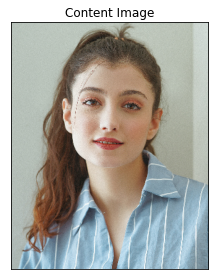

In [6]:
content_img = load_image(content_image_path)
imshow(content_img, 'Content Image')

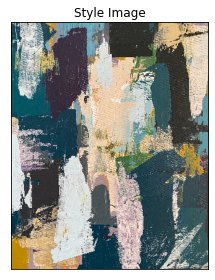

In [7]:
style_img = load_image(style_image_path)
imshow(style_img, 'Style Image')

In [8]:
def preprocess_image(image):
  
  '''
  this function takes in an image and preprocesses it using the VGG-19 preprocessing function
  and return it as a tensor
  '''
  
  img = load_image(image)
  img = preprocess_input(img)
  
  return convert_to_tensor(img) 

In [9]:
def deprocess_image(tensor):
  
  '''
  this function takes in a tensor, applies the opposite of VGG-19 preprocessing function, converts 
  the tensor into RGB and clips the pixel values in the respective color channels between 0 and 255
  '''
  
  tensor = tensor.reshape((IMG_ROW, IMG_COL, 3))
  tensor[:, :, 0] += 103.939
  tensor[:, :, 1] += 116.779
  tensor[:, :, 2] += 123.68
  
  tensor = tensor[:, :, ::-1]
  tensor = np.clip(tensor, 0, 255).astype("uint8")
  
  return tensor

In [10]:
def gram_matrix(x):
    # calculating gram matrix of our input as outer product of features
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    
    return gram
    
def style_loss(style, combination):
    # calculating style loss by using gram matrix function
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = IMG_ROW * IMG_COL
    
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))
    
def content_loss(base, combination):
    # calculating content loss based on Gatys et. al
    return tf.reduce_sum(tf.square(combination - base))   
    
def total_variation_loss(x):
    # calculating total variation loss
    a = tf.square(x[:, : IMG_ROW - 1, : IMG_COL - 1, :] - x[:, 1:, : IMG_COL - 1, :])
    b = tf.square(x[:, : IMG_ROW - 1, : IMG_COL - 1, :] - x[:, : IMG_ROW - 1, 1:, :])
    
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [11]:
model = VGG19(weights="imagenet", include_top = False)    # loading a pre-trained VGG-19 model

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])   # creating outputs for our model

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)    # creating a feature extraction model

style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layer_name = "block5_conv2"

In [12]:
def compute_loss(generated_image, content_image, style_image):
    
    '''
    this function takes in a row-wise concatenated version of our content, style, and generated images 
    and feeds it to our feature extractor - respective losses are then calculated using different layers 
    of the feature extractor and losses are calculated according to the functions defined in the 2016 paper
    by Gatys et. al
    '''
    
    input_tensor = tf.concat(
        [content_image, style_image, generated_image], axis=0
    )
    
    features = feature_extractor(input_tensor)    # passing our input tensor through the feature extractor

    loss = tf.zeros(shape=())   # creating a placeholder for losses initialized to zeros

    layer_features = features[content_layer_name]   # extracting layers for content loss computation
    base_image_features = layer_features[0, :, :, :]    # content features are calculated by using only all channels of tensor 0 i.e., content image
    combination_features = layer_features[2, :, :, :]   # generated features are calculated by using only all channels of tensor 2 i.e., generated image
    loss = loss + CONTENT_WGT * content_loss(base_image_features, combination_features)   # calculating content loss
    
    for layer_name in style_layer_names:
        layer_features = features[layer_name]   # extracting layers for style loss computation
        style_reference_features = layer_features[1, :, :, :]   # style features are calculated by using only all channels of tensor 1 i.e., content image
        combination_features = layer_features[2, :, :, :]   # generated features are calculated by using only all channels of tensor 2 i.e., generated image
        sl = style_loss(style_reference_features, combination_features)   # calculating style loss from i-th layer
        loss += (STYLE_WGT / len(style_layer_names)) * sl   # summing up losses from i layers

    
    loss += VAR_WGT * total_variation_loss(generated_image)   # calculating total variational loss
    
    return loss

In [13]:
@tf.function
def compute_loss_and_grads(generated_image, content_image, style_image):
    
    '''
    this function uses tensorflows gradient tape for automatic calculation of 
    losses and gradients - hence it has been defined as a tf function
    '''
    
    with tf.GradientTape() as tape:
        loss = compute_loss(generated_image, content_image, style_image)
    grads = tape.gradient(loss, generated_image)
    return loss, grads

# setting optimizer to stochastic gradient descent - another choice could be Adam here   
optimizer = SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

content_image = preprocess_image(content_image_path)  # preprocessing content image
style_image = preprocess_image(style_image_path)    # preprocessing style image
generated_image = tf.Variable(preprocess_image(content_image_path))   # preprocessing generated image

steps = 2000  # setting number of steps for running our model

def run_style_transfer(steps = 1000):
    
    '''
    this is our main function for running style transfer by starting a timer, computing
    losses and gradients when we feed our content, style, and generated images to our
    model - and finally applying the optimizer to re-adjust gradients while saving the
    generated image at the respective step
    '''
    
    start_time = time.time()  # start timer
  
    for i in range(1, steps + 1):   # compute losses and gradients at each step
        
        loss, grads = compute_loss_and_grads(
            generated_image, content_image, style_image
        )
        
        optimizer.apply_gradients([(grads, generated_image)])   # use optimizer for adjusting gradients
      
        if i % 100 == 0:
          print("Iteration %d: loss=%.2f" % (i/100, loss))    # printing loss at steps that are a multiple of 100
          img = deprocess_image(generated_image.numpy())    # deprocessing our output tensors into images
          fname = result_prefix + "_at_step_%d.png" % (i/100)   # creating a filename for our image 
          save_img(fname, img)    # saving our images
  
    elapsed_time = time.time() - start_time   # calculating elapsed time for style transfer
    elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))   # formatting elapsed time to make it readable

    print("\nElapsed Time: " + elapsed_time)    # print elapsed time at the end of style transfer

In [14]:
run_style_transfer(steps = 2000)

Iteration 1: loss=4044.53
Iteration 2: loss=3473.79
Iteration 3: loss=3227.39
Iteration 4: loss=3076.84
Iteration 5: loss=2977.22
Iteration 6: loss=2904.40
Iteration 7: loss=2848.21
Iteration 8: loss=2803.59
Iteration 9: loss=2767.09
Iteration 10: loss=2736.67
Iteration 11: loss=2710.64
Iteration 12: loss=2688.06
Iteration 13: loss=2668.39
Iteration 14: loss=2651.07
Iteration 15: loss=2635.63
Iteration 16: loss=2621.71
Iteration 17: loss=2609.09
Iteration 18: loss=2597.64
Iteration 19: loss=2587.23
Iteration 20: loss=2577.70

Elapsed Time: 00:05:05


In [15]:
def show_results(content_image_path, style_image_path, generated_image_path):
  
  '''
  a function that creates a figure and plots our content image, style image
  and generated image side by side for comparison
  '''
  
  plt.figure(figsize=(10,5))

  content = load_image(content_image_path)
  style = load_image(style_image_path)
  generated = load_image(generated_image_path)

  plt.subplot(1, 3, 1)
  imshow(content, 'Content Image')
  plt.xticks([])
  plt.yticks([])

  plt.subplot(1, 3, 2)
  imshow(style, 'Style Image')
  plt.xticks([])
  plt.yticks([])

  plt.subplot(1, 3, 3)
  imshow(generated, 'Generated Image')
  plt.xticks([])
  plt.yticks([])

  plt.tight_layout()

  plt.show()

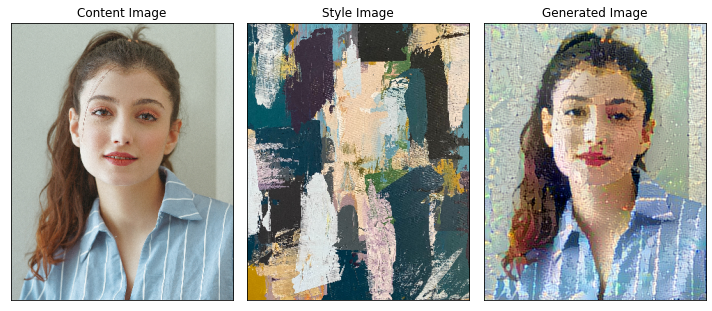

In [16]:
generated_image_path = 'generated_image_at_step_20.png'
show_results(content_image_path, style_image_path, generated_image_path)